# Introduction

This kernel contains the inference code of the submission_experts team for the 2021 HuBMAP competition (version 1). Some additional insights are provided at the end of the notebook.

The goal of the competition was to provide with automated glomeruli segmentation models for WSI of human kidneys. In this competition, these WSI can be divided into two categories: those containing fresh-frozen (FFPE) tissues and those containing formalin-fixed paraffin-embedded tissues. Obvious visual differences can be noticed in both types of WSI: the structure of FFPE tissues is better preserved than fresh-frozen ones. Therefore, we initially tried to apply different models with respect to the type of WSI that we were processing. That approach was giving us very good results on the public leaderboard and on cross-validation before the change of test data, but unfortunately for some reason, we could not see that improvement afterwards. After discussion, we decided not to follow that approach in our final submissions.

In [ ]:
!mkdir -p /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/efficientnet_pytorch-0.6.3.xyz /tmp/pip/cache/efficientnet_pytorch-0.6.3.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/segmentation-models-pytorch-0.1.2.xyz /tmp/pip/cache/segmentation_models_pytorch-0.1.2.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.1.20-py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.2.1-py3-none-any.whl /tmp/pip/cache/
!pip install --no-index --find-links /tmp/pip/cache/ efficientnet-pytorch
!pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch

# Imports
import sys
sys.path.insert(0, "../input/resnest/")
import resnest.torch as resnest_torch

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import random
import rasterio
import tempfile
import cv2
import os
import shutil
import gc
from tqdm.notebook import tqdm
import time
import skimage.measure

from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import ResNet, Bottleneck
import segmentation_models_pytorch as smp

from fastai.vision.all import PixelShuffle_ICNR, ConvLayer # TODO: remove

import warnings
warnings.filterwarnings("ignore")

# Training Tricks

## Disclamer

We used NO hand-labelling and manual annotation since in our vision it is not consistent with the initial goal and objective of the competition.

## Color spaces augmentation trick:

For the training we found and decided to use various Color Space Augmentations in combination with custom stochastic kernel - this is one of the most important things that allowed our models to stay robust and segment glomeruli despite the data source, type of the images (FFPE/fresh-frozen/even others) and "color-related" variations. 

On the images below one could see how the naturally looked tiles are transformed being augmented with this method. You can see normal tiles with the cutmix augs, color spaced without cutmix, and color spaced with cutmix.


**Tiles with CutMix augmentation:**

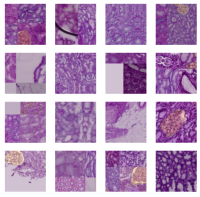

**Tiles with Color Space augmentation:**

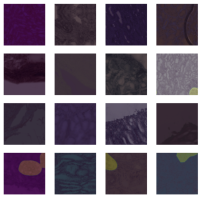

**Tiles with both augmentations:**

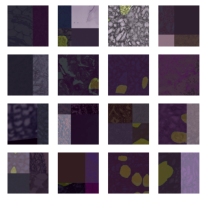

This methodology demonstrated its effectiveness and power during both stages of the competition, but mostly with the first set of the data (maybe due to the different test sets, since we dont know yet results on the private test data).

We also share the code as we implemented this idea.


```
import cv2

cspaces = [cv2.COLOR_BGR2HLS,

            cv2.COLOR_BGR2HSV,

            cv2.COLOR_BGR2LAB,

            cv2.COLOR_BGR2LUV,

            cv2.COLOR_BGR2Lab,

            cv2.COLOR_BGR2Luv,

            cv2.COLOR_BGR2RGB,

            cv2.COLOR_BGR2XYZ,

            cv2.COLOR_BGR2YUV,

            cv2.COLOR_RGB2HLS,

            cv2.COLOR_RGB2HSV,

            cv2.COLOR_RGB2LAB,

            cv2.COLOR_RGB2LUV,

            cv2.COLOR_RGB2Lab,

            cv2.COLOR_RGB2Luv,

            cv2.COLOR_RGB2BGR,

            cv2.COLOR_RGB2XYZ,

            cv2.COLOR_RGB2YUV]
```


In the batch sampling part:
 

```
if self.train and random.random() > 1/len(cspaces):

    cspace = random.choice(cspaces)

    img = cv2.cvtColor(img, cspace)

if self.train:

    stoch = np.random.rand(3,3)

    K = stoch.sum(0, keepdims=True)

    if random.random() > 0.7:

        K=np.exp(K)/K

    elif random.random() > 0.25:

        K=np.exp(K)/(np.sqrt(K))

    stoch = stoch/K

    img = np.einsum("ijk,kl->ijl", img, stoch)
```

This method also allowed to obtain much more focused predictions - we observed very high “soft dice” metrics even without proper binarization threshold. For example improvement is from 0.6-0.65 in the standard pipeline up to 0.87-0.89 Dice, depending on the fold.

Additionally we observed interesting behaviour such as robust segmentation even of some suspicious glomeruli in the d48*** sample from public test set.

## Multi-scale input tiles

We used multiple image reduction rates (3, 4, 5, 6 and 8) in order to create the tiles from original images. Additionally we used only “non-empty” tiles of the bigger reduction rates to balance more the training dataset. Such approach naturally increases the training dataset and enriches variation of glomeruli size and its proportion in the considered tile of fixed size.

This also gave us significant boost both in CV and LB.

## Pseudo-labelling

Public test set pseudo-labeled with own models and included in the training procedure

## Short training pipeline

Unet with resnext50_32x4d/resnext101_32x16d/efficientnet-b7/b5 backbones, ASPP and FPN modules + complex loss (combination of FocalLoss + DiceLoss + SymmetricLovasz) + OneCycleLR + Heavy Augmentations & CutMix & ColorSpaced augs + 5-fold patient-based CV.

# Inference

In this section, we describe how we make predictions.

## Inference in a nutshell

- We make an inference on the bigger patch size than was used for training. Before the data update the best one was of 1024 and after - 512 while the training is performed on 256x256.

- We used overlapping step of 0.5xtile_size in both X and Y directions to cut the patches from test images. Locally we used smaller step of 0.33 that wasn't used because of the inference time constraints.

- We also used classical TTA based on transformations of the D4 group, but we were limited by the kernel inference time.

- In order to handle the WSI images size we used memmap to load the images, and also used temporary saving of processed patches to perform the ensembling.

- Very important point that we wanted to highlight, that we were able to split all test images into two groups with respect to the ffpe/ff type using the "PhysicalSizeY" from the tiff.pages.description. This information was crucial before the data update and allowed us to get different models that worked for each of the groups. However, by some reasons (we did not discover which) this stopped working after the data update (at least for the public LB). But it still demonstrated higher CV when models were trained independently for each group.

- This version makes a two-pass segmentation: a first pass aims at finding where glomeruli are (detection threshold is very low) and a second pass aims at refining segmentations by applying our models on tiles centered on glomeruli found during the first pass.

- Final submissions are ensembles of models trained with and without Color Space Augmenatations and Cutmix in order to increase the robustness.

## Parameters

Here are the parameters that we use for inference.

In [ ]:
# PARAMETERS

# Printing parameters
VERBOSE = True

# Data processing
DATA_DIR = '../input/hubmap-kidney-segmentation/test' # Input data directory
REDUCTION = 3 # Reduce the original images by x times
TILE_SZ = 768 # Size of tiles on which inference is done
TILE_SZ_2nd = 384
# https://www.kaggle.com/iafoss/256x256-images
#MEAN = np.array([0.65459856,0.48386562,0.69428385])
#STD = np.array([0.15167958,0.23584107,0.13146145])
MEAN = np.array([0.63482309,0.47376275,0.67814029])
STD = np.array([0.17405236,0.23305763,0.1585981])

# Models for first pass
MODELS_PATHS_1st = [f'../input/ens-red345/model_ux50_{i}.pth' for i in range(2)]

# Models for second pass
MODELS_PATHS_2nd = [f'../input/ens-red345/model_effb5_{i}.pth' for i in range(2)]
MODELS_PATHS_2nd += [f'../input/ens-red345/model_effb7_{i}.pth' for i in [1,3]]
MODELS_PATHS_2nd += [f'../input/ret-r101-multi3468-lf/model_{i}.pth' for i in [0,2]]
#MODELS_PATHS_2nd += [f'../input/ens-red345/model_rnst200_{i}.pth' for i in range(1)]

# Tiles selection
# https://www.kaggle.com/iafoss/256x256-images
S_TH = 40 # Saturation blancking threshold
P_TH = 200*TILE_SZ//256 # Threshold for the minimum number of pixels

# Size of center check box
CHECK_SZ = 256

# Inference
PUBLIC_ONLY = False # Make predictions only on public LB
X_OVERLAP = [0., 0.5] # Overlap between tiles during prediction (X axis)
Y_OVERLAP = [0., 0.5] # Overlap between tiles during prediction (Y axis)
CUSTOM_RED = 1 # Reduction for two types of models
TH_1st = 0.1 # Threshold for first pass
TH_2nd = 0.3 # Threshold for second pass
N_BINS = 255 # Number of bins when saving mask tiles
BATCH_SIZE = 2
NUM_WORKERS = 2
HALF_PRECISION = False
TTA_FLIPS = [[-1], [-2], [-2, -1]]
ROT_TTA_FLIPS = [0, 1]

# Final prediction
MASK_SZ = 4096 # Size of saved mask tiles

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists('tmp'):
    if VERBOSE:
        print("Removing 'tmp' directory")
    shutil.rmtree('tmp')

### Models

The models that we can use for inference are defined below.

In [ ]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(nn.Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:torch.Tensor, left_in:torch.Tensor) -> torch.Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = ResNet(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4)
        #m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
        #                   'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x
    
    
    
class UneXt101(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = ResNet(Bottleneck, [3, 4, 23, 3], groups=32, width_per_group=16)

        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x
    
class Unet50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
#         m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
#                            'resnet50_swsl')
        m = ResNet(Bottleneck, [3, 4, 6, 3])
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

class UneSt200(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = getattr(resnest_torch, 'resnest200')(pretrained=False)
    
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(m.maxpool,
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.3)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,128,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.2)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

def Effb7Unet():
    return smp.Unet(encoder_name='efficientnet-b7', classes=1, activation=None, encoder_weights=None)

def Effb5Unet():
    return smp.Unet(encoder_name='efficientnet-b5', classes=1, activation=None, encoder_weights=None)

We import them as follows.

In [ ]:
# Model name to class
modelname2class = {"ux50": UneXt50,
                   "0.pth": UneXt101,
                   "2.pth": UneXt101,
                   "effb5": Effb5Unet,
                   "effb7": Effb7Unet,
                   "rnst200": UneSt200}

# Import models
MODELS_1st = []
for path in MODELS_PATHS_1st:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model_name = path.split("_")[1]
    model = modelname2class[model_name]()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    MODELS_1st.append(model)
    del state_dict

MODELS_2nd = []
for path in MODELS_PATHS_2nd:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model_name = path.split("_")[1]
    model = modelname2class[model_name]()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    MODELS_2nd.append(model)
    del state_dict

# Detailed Description of our Inference Approach

In this section, we describe our approach (version 1). The second version, using a two-pass segmentation, is described in a separate notebook.

## Data Preprocessing

Data preprocessing consists in downsampling images. We also initially wanted to find to which group (fresh-frozen vs FFPE) they belonged to, but as we said before, we finally did not follow that approach. We copy our group-finding code for information.

### Loading and Downsampling Whole-Slide Images

The main issue with WSI is that they are very big. Here is how we load an image, using NumPy MemMap.

In [ ]:
def read_tiff(filename):
    img = rasterio.open(filename)
    W, H = img.shape
    tmp = np.memmap(tempfile.TemporaryFile(), shape=(W, H, 3),
                          dtype=np.uint8)
    if len(img.subdatasets) == 3:
        for i in range(3):
            tmp[:,:,i] = rasterio.open(img.subdatasets[i]).read(1)
    else:
        for i in range(3):
            tmp[:,:,i] = img.read(i+1)
    return tmp

def load_image(filename):
    img_id = filename.split("/")[-1].split(".")[0]
    img = read_tiff(filename)
    if VERBOSE:
        print("Initial size of %s:" %(img_id,), img.shape)
    return img

Dealing with such big images is not convenient, we found that we should downsample data for better performance. After loading the image using the `load_image` function above, we apply the `_tile_resize_save` function below.

In [ ]:
def _tile_resize_save(img, img_id, tile_sz, reduce=1):
    """
    Divide WSI into small tiles, resize them and save them locally.
    """
    x = 0
    while x < img.shape[0]:
        y = 0
        while y < img.shape[1]:
            # Get tile
            img_tile = img[x:x+tile_sz,y:y+tile_sz]

            # Reduce if needed
            if reduce > 1:
                new_dim = (img_tile.shape[1]//reduce,img_tile.shape[0]//reduce)
                img_tile = cv2.resize(img_tile, new_dim, interpolation = cv2.INTER_AREA)

            # Save tile
            save_path = "%s_%d_%d.png" %(img_id, x//reduce, y//reduce)
            Image.fromarray(img_tile).save(save_path)
            y += tile_sz
        x += tile_sz

    # Return dimension after reduction
    final_x = ((x-tile_sz)//tile_sz)*(tile_sz//reduce) + img_tile.shape[0]
    final_y = ((y-tile_sz)//tile_sz)*(tile_sz//reduce) + img_tile.shape[1]
    return (final_x, final_y, 3)

Then, we must reconstruct the image from resampled tiles that we saved. For that purpose, we apply the following `_reconstruct_img` function.

In [ ]:
def _reconstruct_img(img_id, tile_sz, shape):
    """
    Reconstruct image from reduced tiles.
    """

    img = np.zeros(shape, dtype=np.uint8)
    if VERBOSE:
        print("Reconstructed image:", shape)
    x = 0
    while x < shape[0]:
        y = 0
        while y < shape[1]:
            tile_path = "%s_%d_%d.png" %(img_id, x, y)
            img_tile = np.asarray(Image.open(tile_path))
            img[x:x+tile_sz,y:y+tile_sz] = img_tile
            os.remove(tile_path) # Tiles are deleted when read
            y += tile_sz
        x += tile_sz
    return img

All put together, the result is the following `load_resize` function.

In [ ]:
def load_resize(idx, reduce):
    """
    Memory efficient WSI loading and resampling.
    Return resampled image and initial shape.
    """
    img = load_image(os.path.join(DATA_DIR,idx+'.tiff'))
    init_shape = img.shape
    shape = _tile_resize_save(img, idx, (MASK_SZ*REDUCTION), reduce=REDUCTION)
    img = _reconstruct_img(idx, (MASK_SZ*REDUCTION)//REDUCTION, shape)
    return img, init_shape

## Making Predictions

In this section, we describe how we make predictions.

### Padding for the first pass

As images are very big, we must divide them into tiles. We added zero-padding to make the dimensions of the image dividable by the tile size. Ensembling predictions with different padding dimensions allows us to avoid bad predictions due to glomeruli located on edges of the tiles. This is only necessary during the first pass as the second pass will operate on pre-selected tiles.

In [ ]:
def _get_nored_pads_1st(initW, initH, upW, upH, xa, xb, ya, yb):
    """
    Get padding to remove in final mask.
    """
    px = xa/(xa+xb)
    py = ya/(ya+yb)
    padx = upW - initW
    pady = upH - initH
    assert padx > 0
    assert pady > 0
    xa = int(px*padx)
    xb = padx - xa
    ya = int(py*pady)
    yb = pady - ya
    return xa, xb, ya, yb

def _add_padding_1st(img, p0, p1):
    """
    Add padding to make the image dividable into tiles.
    """
    start = time.time()
    if VERBOSE:
        print("  > Adding padding to make the image dividable into tiles...")

    # X overlap padding
    pad0_ = TILE_SZ - img.shape[0]%TILE_SZ
    x_pad = int(TILE_SZ*p0)
    xa = (pad0_//2 + x_pad)
    xb = pad0_+TILE_SZ-(pad0_//2 + x_pad)
    pad0_lr = [xa, xb]

    # Y overlap padding
    pad1_ = TILE_SZ - img.shape[1]%TILE_SZ
    y_pad = int(TILE_SZ*p1)
    ya = (pad1_//2 + y_pad)
    yb = pad1_+TILE_SZ-(pad1_//2 + y_pad)
    pad1_lr = [ya, yb]

    img = np.pad(img, [pad0_lr, pad1_lr, [0, 0]], constant_values=0)
    if VERBOSE:
        print("  > After padding:", img.shape, "Time =", time.time() - start, "s")
    return img, xa, xb, ya, yb

### Dividing the Image into Tiles

The following ``_split_image_1st`` function allows us to divide images into tiles.

In [ ]:
def _split_image_1st(img):
    """
    Split image into tiles using the reshape+transpose trick.
    Final shape = [nb_x*nb_y, TILE_SZ, TILE_SZ, 3].
    """
    start = time.time()
    if VERBOSE:
        print("  > Splitting image into tiles...")
    assert not img.shape[0]%TILE_SZ # Check that width is OK
    assert not img.shape[1]%TILE_SZ # Check that height is OK
    img = img.reshape(img.shape[0]//TILE_SZ,
                      TILE_SZ,
                      img.shape[1]//TILE_SZ,
                      TILE_SZ,
                      3)
    img = img.transpose(0,2,1,3,4).reshape(-1,TILE_SZ,TILE_SZ,3)
    if VERBOSE:
        print("  > Splitting done! Time =", time.time() - start)
    return img

Then (for the first pass) we select tiles on which we will make predictions based on their color saturations.

In [ ]:
def _select_tiles_1st(img):
    """
    Select tiles for running the model.
    """
    start = time.time()
    if VERBOSE:
        print("  > Selecting tiles...")
    if not os.path.exists('tmp'):
        # Generate tmp directory if needed
        os.makedirs('tmp')
    idxs = []
    for i, im in enumerate(img):
        # Remove black or gray images based on saturation check
        hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if (s>S_TH).sum() <= P_TH or im.sum() <= P_TH: continue 
        cv2.imwrite("tmp/%d.png" %(i,), im)
        idxs.append(i)
    if VERBOSE:
        print("  > Tiles selected! Time =", time.time() - start)
    return idxs

Eventually, we need a DataLoader to feed data to our model. This DataLoader is based on the `HuBMAPTestDataset1st` and the `HuBMAPTestDataset2nd` class below. As said before, the `HuBMAPTestDataset2nd` does not need the tile selection process we mentioned.

In [ ]:
def img2tensor(img, dtype:np.dtype=np.float32):
    if img.ndim==2: img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPTestDataset1st(Dataset):
    def __init__(self, idxs):
        self.fnames = idxs
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        im = cv2.imread("tmp/%d.png" %(self.fnames[idx],))
        return img2tensor((im/255.0 - MEAN)/STD)

class HuBMAPTestDataset2nd(Dataset):
    def __init__(self, centroids, img):
        self.centroids = centroids
        self.img = img
        
    def __len__(self):
        return len(self.centroids)
    
    def __getitem__(self, idx):
        x, y = self.centroids[idx]
        xa, ya = round(x) - TILE_SZ_2nd//2, round(y) - TILE_SZ_2nd//2
        xb, yb = xa + TILE_SZ_2nd, ya + TILE_SZ_2nd
        xa = max(0, xa)
        ya = max(0, ya)
        im = np.zeros((TILE_SZ_2nd, TILE_SZ_2nd, 3))
        tmp_im = self.img[xa:xb, ya:yb]
        padx = TILE_SZ_2nd - tmp_im.shape[0]
        pady = TILE_SZ_2nd - tmp_im.shape[1]
        im[padx//2:padx//2+tmp_im.shape[0],pady//2:pady//2+tmp_im.shape[1]] = tmp_im
        return img2tensor((im/255.0 - MEAN)/STD)

The aforementioned DataLoader is generated using the following `_make_tiles_dataloader_1st` and `_make_tiles_dataloader_1st` functions.

In [ ]:
def _make_tiles_dataloader_1st(idxs):
    """
    Make tiles dataset.
    """
    start = time.time()
    ds = HuBMAPTestDataset1st(idxs)
    dl = DataLoader(ds, BATCH_SIZE,
                    num_workers=NUM_WORKERS,
                    shuffle=False,
                    pin_memory=True)
    if VERBOSE:
        print("  > Tiles dataset created! Time =", time.time() - start)
    return dl

def _make_tiles_dataloader_2nd(centroids, img):
    """
    Make tiles dataset.
    """
    start = time.time()
    ds = HuBMAPTestDataset2nd(centroids, img)
    dl = DataLoader(ds, BATCH_SIZE,
                    num_workers=NUM_WORKERS,
                    shuffle=False,
                    pin_memory=True)
    if VERBOSE:
        print("  > Tiles dataset created! Time =", time.time() - start)
    return dl

### Generating the Segmentation Mask

The segmentation mask is then generated. It is not yet binarized. The `_generate_masks_1st` and `_generate_masks_2nd` function outputs a zero-padded mask. Only after the second pass function `_generate_masks_2nd`, the mask is upsampled to match the original image.

In [ ]:
def _generate_masks_1st(dl, idxs, n_tiles, init_sz):
    """
    Generate masks.
    """
    start = time.time()
    if VERBOSE:
        print("  > Generating masks...")
    mp = Model_pred_1st(MODELS_1st, dl, CUSTOM_RED)
    mask = torch.zeros(n_tiles,
                       init_sz,
                       init_sz,
                       dtype=torch.uint8)
    for i, p in zip(idxs,iter(mp)): mask[i] = p.squeeze(-1)
    if VERBOSE:
        print("  > Masks generated! Time =", time.time() - start)
    return mask

def _generate_masks_2nd(dl, centroids, init_shape):
    """
    Generate masks.
    """
    start = time.time()
    if VERBOSE:
        print("  > Generating masks...")
    mp = Model_pred_2nd(MODELS_2nd, dl, CUSTOM_RED)
    W, H = init_shape[:2]
    alpha = REDUCTION*CUSTOM_RED
    mask = torch.zeros(W+TILE_SZ_2nd*2*alpha,
                       H+TILE_SZ_2nd*2*alpha,
                       dtype=torch.uint8)
    for c, p in zip(centroids, iter(mp)):
        x, y = c
        x1 = round(x)*alpha - (TILE_SZ_2nd*alpha)//2 + TILE_SZ_2nd*alpha
        y1 = round(y)*alpha - (TILE_SZ_2nd*alpha)//2 + TILE_SZ_2nd*alpha
        x2 = x1 + TILE_SZ_2nd*alpha
        y2 = y1 + TILE_SZ_2nd*alpha
        # print(x1, x2, y1, y2, p.shape)
        mask[x1:x2,y1:y2] = torch.maximum(mask[x1:x2,y1:y2], p)
    if VERBOSE:
        print("  > Final mask generated! Time =", time.time() - start)
    return mask[TILE_SZ_2nd*alpha:-TILE_SZ_2nd*alpha,TILE_SZ_2nd*alpha:-TILE_SZ_2nd*alpha]

The `_generate_masks_1st` and `_generate_masks_2nd` functions are based on the `Model_pred_1st` and `Model_pred_2nd` iterator-like class that is used to generate predictions. During the second pass, predictions are upsampled to match the original image. The `Model_pred_2nd` class makes predictions on pre-selected tiles, and then only keeps glomeruli whose intersection with a center square of predefined dimensions is non-empty: this is to avoid problems encountered with detections close to edges, that are often wrong.

In [ ]:
# Iterator-like wrapper that returns predicted masks
class Model_pred_1st:
    def __init__(self, models, dl, red, half:bool=False):
        self.models = models # List of models
        self.dl = dl # Dataloader
        self.half = half # Half precision
        self.red = red # Reduction on reduced image
        
    def __iter__(self):
        with torch.no_grad():
            for x in iter(self.dl):
                # Prepare input
                x = x.to(device)
                x = F.interpolate(x, scale_factor=1/self.red, mode='bilinear')
                if self.half: x = x.half()

                # Make predictions
                py = 0.
                for rot_flip in ROT_TTA_FLIPS: #[0,1]
                    for model in self.models:
                        xr = torch.rot90(x, rot_flip, [-2, -1])
                        p = model(xr)
                        p = torch.rot90(p, -rot_flip, [-2, -1])
                        p = torch.sigmoid(p).detach()
                        py += p
                    for f in TTA_FLIPS:
                        xf = torch.rot90(x, rot_flip, [-2, -1])
                        xf = torch.flip(xf,f)
                        for model in self.models:
                            p = model(xf)
                            p = torch.flip(p,f)
                            p = torch.rot90(p, -rot_flip, [-2, -1])
                            py += torch.sigmoid(p).detach()
                        
                py /= (1+len(TTA_FLIPS))*len(ROT_TTA_FLIPS)       
                py /= len(self.models)

                py = py.permute(0,2,3,1).float().cpu()

                # Quantize probablities to save memory
                py = (N_BINS*py).int()

                # Output predictions
                batch_size = len(py)
                for i in range(batch_size):
                    yield py[i]
                    
    def __len__(self):
        return len(self.dl.dataset)

class Model_pred_2nd:
    def __init__(self, models, dl, red, half:bool=False):
        self.models = models # List of models
        self.dl = dl # Dataloader
        self.half = half # Half precision
        self.red = red # Reduction on reduced image
        
    def __iter__(self):
        with torch.no_grad():
            for x in iter(self.dl):
                # Prepare input
                x = x.to(device)
                x = F.interpolate(x, scale_factor=1/self.red, mode='bilinear')
                if self.half: x = x.half()

                # Make predictions
                py = 0.
                for rot_flip in ROT_TTA_FLIPS: #[0,1]
                    for model in self.models:
                        xr = torch.rot90(x, rot_flip, [-2, -1])
                        p = model(xr)
                        p = torch.rot90(p, -rot_flip, [-2, -1])
                        p = torch.sigmoid(p).detach()
                        py += p
                    for f in TTA_FLIPS:
                        xf = torch.rot90(x, rot_flip, [-2, -1])
                        xf = torch.flip(xf,f)
                        for model in self.models:
                            p = model(xf)
                            p = torch.flip(p,f)
                            p = torch.rot90(p, -rot_flip, [-2, -1])
                            py += torch.sigmoid(p).detach()
                        
                py /= (1+len(TTA_FLIPS))*len(ROT_TTA_FLIPS)       
                py /= len(self.models)

                # Upsample to initial shape
                py = F.upsample(py, scale_factor=REDUCTION*self.red, mode="bilinear")

                py = (py > TH_2nd).permute(0,2,3,1).int().cpu()[:,:,:,0]
                new_py = torch.zeros(py.shape).int()
                c1 = (REDUCTION*TILE_SZ_2nd*self.red)//2 - (REDUCTION*CHECK_SZ*self.red)//2
                c2 = c1 + REDUCTION*CHECK_SZ*self.red
                for i, py_i in enumerate(py):
                    label_py_i = skimage.measure.label(py_i.detach().numpy())
                    check = label_py_i[c1:c2,c1:c2].max()
                    for j in range(check+1):
                        if j and (label_py_i[c1:c2,c1:c2] == j).max():
                            new_py[i] += (torch.Tensor(label_py_i == j).int()*py_i).int()
                            '''if random.random() > 0.9:
                                plt.figure()
                                plt.imshow(torch.Tensor(label_py_i == j).numpy())
                                plt.figure()
                                plt.imshow(py_i.float().cpu().detach().numpy())
                                plt.figure()
                                plt.imshow(new_py[i].float().cpu().detach().numpy())
                                plt.figure()
                                plt.imshow(x[i].permute(1, 2, 0).cpu().detach().numpy())'''
                # py = new_py
                # Output predictions
                batch_size = len(py)
                for i in range(batch_size):
                    yield new_py[i]
                    
    def __len__(self):
        return len(self.dl.dataset)

The next step for the first pass is to remove padding.

In [ ]:
def _reshape_depad_mask_1st(mask, init_shape, init_sz, p0, p1, xa, xb, ya, yb):
    """
    Reshape tiled masks into a single mask and crop padding.
    """
    start = time.time()
    if VERBOSE:
        print("  > Merge tiled masks into one mask and crop padding...")
    mask = mask.view(init_shape[0]//TILE_SZ,
                     init_shape[1]//TILE_SZ,
                     init_sz,
                     init_sz).\
                permute(0,2,1,3).reshape(init_shape[0],
                                         init_shape[1])
    mask = mask[xa:-xb,ya:-yb]
    if VERBOSE:
        print("  > Mask created! Shape =", mask.shape,"Time =", time.time() - start)
    return mask

### Saving the Segmentation Mask

The segmentation mask is then saved as tiles containing scores (it is not binarized yet).

In [ ]:
def _save_mask_tiles_1st(mask, idx, p0, p1):
    start = time.time()
    if VERBOSE:
        print("  > Saving tiles in HDD memory...")
    x = 0
    while x < mask.shape[0]:
        y = 0
        while y < mask.shape[1]:
            mask_tile = mask[x:x+MASK_SZ,y:y+MASK_SZ].numpy()
            save_path = "%s_%d_%d_%s_%s.png" %(idx, x, y, str(p0), str(p1))
            Image.fromarray(mask_tile).save(save_path)
            y += MASK_SZ
        x += MASK_SZ
    if VERBOSE:
        print("Tiles saved! Time =", time.time() - start)

All these functions are combined in `make_one_prediction_1st` and `make_one_prediction_2nd`, that aim at saving segmentation mask tiles based on an image and a given set of padding parameters for the first pass.

In [ ]:
def make_one_prediction_1st(img, idx, img_shape, p0, p1):
    """
    Predict a mask for one given image.
    """

    init_sz = TILE_SZ

    # Add padding to make the image dividable into tiles
    img, xa, xb, ya, yb = _add_padding_1st(img, p0, p1)
    img_shape_p = img.shape

    # Split image into tiles using the reshape+transpose trick
    # Final shape = [nb_x*nb_y, TILE_SZ, TILE_SZ, 3]
    img = _split_image_1st(img)
    n_tiles = img.shape[0]

    # Select tiles for running the model
    idxs = _select_tiles_1st(img)

    # Make tiles dataset
    dl = _make_tiles_dataloader_1st(idxs)

    # Generate masks
    mask = _generate_masks_1st(dl, idxs, n_tiles, init_sz)

    # Reshape tiled masks into a single mask and crop padding
    mask = _reshape_depad_mask_1st(mask, img_shape_p, init_sz,
                               p0, p1, xa, xb, ya, yb)

    # A little bit of cleaning...
    gc.collect()
    shutil.rmtree('tmp')

    # Save tiles in HDD memory
    _save_mask_tiles_1st(mask, idx, p0, p1)

def make_one_prediction_2nd(img, idx, img_shape, centroids):
    """
    Predict a mask for one given image.
    """

    init_sz = TILE_SZ_2nd

    # Make tiles dataset
    ds = HuBMAPTestDataset2nd(centroids, img)
    dl = DataLoader(ds, BATCH_SIZE,
                num_workers=NUM_WORKERS,
                shuffle=False,
                pin_memory=True)

    # Generate masks
    mask = _generate_masks_2nd(dl, centroids, img_shape)

    return mask

Segmentation mask tiles are generated, for all possible sets of padding parameters for the first pass, using the following `get_mask_tiles_1st` and `get_mask_tiles_2nd` functions.

In [ ]:
def get_mask_tiles_1st(idx, p0_list, p1_list):
    """
    Load a WSI and generate mask tiles.
    Return initial shape of WSI and binarization threshold.
    """
    img, init_shape = load_resize(idx, REDUCTION)
    for p0 in p0_list:
        for p1 in p1_list:
            make_one_prediction_1st(img, idx, init_shape, p0, p1)
    return init_shape, img

def get_mask_tiles_2nd(img, idx, init_shape, centroids):
    """
    Load a WSI and generate mask tiles.
    Return initial shape of WSI and binarization threshold.
    """
    mask = make_one_prediction_2nd(img, idx, init_shape, centroids)
    return mask

## Generating Final Predictions

Final predictions are generated stacking the outputs of the `make_predictions_1st` function and the `make_predictions_2nd` function through the `get_mask_tiles_1st` and `get_mask_tiles_2nd` functions. Eventually, the obtained mask is converted into RLE format.

In [ ]:
def make_predictions_1st(idx):
    """
    Generate bounding-box predictions for idx.
    """

    # First generate mask tiles
    init_shape, img = get_mask_tiles_1st(idx, X_OVERLAP, Y_OVERLAP)

    # Then reconstruct mask from tiles
    mask = torch.zeros(*img.shape[:2], dtype=torch.uint8)
    x = 0
    while x < img.shape[0]:
        y = 0
        while y < img.shape[1]:
            mask_tile = 0.
            for p0 in X_OVERLAP:
                for p1 in Y_OVERLAP:
                    tile_path = "%s_%d_%d_%s_%s.png" %(idx, x, y, str(p0), str(p1))
                    mask_tile += torch.tensor(np.asarray(Image.open(tile_path), dtype=int))
                    os.remove(tile_path)
            NEW_TH = int(N_BINS*len(X_OVERLAP)*len(Y_OVERLAP)*TH_1st)
            mask[x:x+MASK_SZ,y:y+MASK_SZ] = mask_tile>NEW_TH
            y += MASK_SZ
        x += MASK_SZ

    #plt.figure()
    #plt.imshow(mask[2750:3750,5000:6000])

    # Get bounding boxes
    label_mask = skimage.measure.label(mask)
    bboxes = skimage.measure.regionprops(label_mask)
    centroids = [x.centroid for x in bboxes]
    return img, init_shape, centroids

def make_predictions_2nd(idx, img, init_shape, centroids):
    """
    Generate bounding-box predictions for idx.
    """

    mask = get_mask_tiles_2nd(img, idx, init_shape, centroids)
    #plt.figure()
    #plt.imshow(mask[11000:15000,20000:24000].float().numpy())
    #plt.figure()
    #plt.imshow(img[2750:3750,5000:6000])
    # Eventually convert to rle
    # https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
    if VERBOSE:
        print("  > Converting to RLE...")
    rle = rle_encode_less_memory(mask.numpy())
    del mask
    return rle

The RLE conversion is done using the following `rle_encode_less_memory` function, obtained from https://www.kaggle.com/bguberfain/memory-aware-rle-encoding.


In [ ]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
def rle_encode_less_memory(img):
    #watch out for the bug
    pixels = img.T.flatten()
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Submission

Here is the final part of this kernel, dealing with the actual submission of a CSV file containing generated masks.

Image names from public and private test sets are retrieved from the sample_submission.csv file that is provided. If `PUBLIC_ONLY = True`, then we only make the prediction for public test data.

In [ ]:
df_sample = pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv')
names,preds = [],[]
if PUBLIC_ONLY:
    samples = ['d488c759a', 'aa05346ff','57512b7f1','3589adb90','2ec3f1bb9']
    samples_n = [id for id in df_sample.id if id not in samples]

    for x in samples_n:
        names += [x]
    preds += [np.NaN]*len(samples_n)
    df_sample = df_sample.loc[df_sample.id.isin(samples)]

Then we generate masks for each image in the test set.

In [ ]:
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    idx = row['id']
    print("Computing predictions for image", idx)
    img, init_shape, centroids = make_predictions_1st(idx)
    rle = make_predictions_2nd(idx, img, init_shape, centroids)
    names.append(idx)
    preds.append(rle)

And finally we generate a submission.csv file containing all our predictions.

In [ ]:
df = pd.DataFrame({'id': names, 'predicted': preds})
df.to_csv('submission.csv',index=False)

# Insights

Thanks to our predictions, we could compute some metrics about glomeruli. In particular we were interested in the median area per patient, the median perimeter per patient and the median ratio area/(perimeter²) per patient. Here are the values we obtained based on the GT for images in the training set and based on our predictions for images in the test set.

| id        | median area (µm²) | median perimeter (µm) | median area/perimeter² |
|-----------|-------------------|-----------------------|------------------------|
| 0486052bb | 5610              | 309                   | 0.059                  |
| 2f6ecfcdf | 34158             | 708                   | 0.068                  |
| 8242609fa | 32320             | 683                   | 0.069                  |
| aaa6a05cc | 13466             | 436                   | 0.071                  |
| b2dc8411c | 24430             | 594                   | 0.069                  |
| b9a3865fc | 15859             | 483                   | 0.068                  |
| cb2d976f4 | 13378             | 435                   | 0.071                  |
| 095bf7a1f | 29992             | 651                   | 0.071                  |
| 1e2425f28 | 8768              | 356                   | 0.069                  |
| 26dc41664 | 28316             | 649                   | 0.067                  |
| 4ef6695ce | 22636             | 574                   | 0.069                  |
| 54f2eec69 | 32392             | 684                   | 0.069                  |
| afa5e8098 | 21632             | 577                   | 0.065                  |
| c68fe75ea | 34348             | 720                   | 0.067                  |
| e79de561c | 33504             | 704                   | 0.068                  |
| 2ec3f1bb9 | 19719             | 529                   | 0.070                  |
| 3589adb90 | 28081             | 630                   | 0.071                  |
| 57512b7f1 | 38216             | 741                   | 0.070                  |
| aa05346ff | 55608             | 1122                  | 0.044                  |
| d488c759a | 11376             | 403                   | 0.070                  |

We found that the median area of glomeruli was negatively correlated to the weight (correlation coefficient of -0.40), the height (-0.39) and the BMI (-0.12). The median perimeter was similarly correlated (respectively -0.46, -0.40 and -0.20). The median area/(perimeter²), describing how complex the shape of the glomeruli were, has been found to be correlated to the weight (0.22), the height (0.16) and the BMI (0.19).

However these findings must be confirmed on more patients, as they are based on a very small sample of people that is not necessarily representative of the general population.